In [1]:
import socket
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
HOST = "127.0.0.1"

In [3]:
class FinalServer:
    def __init__(self, server_port, block_size=1024):
        self.server_port = server_port
        self.block_size = block_size
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.socket.bind((HOST, server_port))
        self.socket.listen()

    def run(self):
        with self.socket as s:
            print(f'Ожидание соединения на порту {self.server_port}.')
            conn, addr = s.accept()
            print(f'Соединение установлено. Порт:{self.server_port}.')

            # Получение изображения с наложенным шумом
            self.img_noise = self.recv_image(conn)
            # Получение оригинального изображения
            self.img_orig = self.recv_image(conn)

        # Получение изображения с шумоподавлением
        self.img_denoise = self.denoise(self.img_noise)

    def recv_image(self, conn):
        # Получение размеров изображения
        h_bytes = conn.recv(4)
        h = int.from_bytes(h_bytes, byteorder='big')
        w_bytes = conn.recv(4)
        w = int.from_bytes(w_bytes, byteorder='big')
        print(f'Размер изображения h = {h} w = {w}.')

        # Получение изображения
        n = h * w * 3
        n_iters = n // self.block_size
        n_remainder = n - n_iters * self.block_size
        img_bytes = []
        for i in range(n_iters):
            block = conn.recv(self.block_size)
            img_bytes.append(block)
        if n_remainder > 0:
            block = conn.recv(n_remainder)
            img_bytes.append(block)
        print('Изображение получено.')

        img_bytes_b = b''.join(img_bytes)
        img_np = np.frombuffer(img_bytes_b, dtype='uint8')
        img = img_np.reshape(h, w, 3)
        return img

    def denoise(self, image):
        return cv2.medianBlur(image, ksize=5)

In [4]:
finalserver = FinalServer(server_port=5066)
finalserver.run()

Ожидание соединения на порту 5066.
Соединение установлено. Порт:5066.
Размер изображения h = 1280 w = 2048.
Изображение получено.
Размер изображения h = 1280 w = 2048.
Изображение получено.


In [5]:
img_orig = finalserver.img_orig
img_noise = finalserver.img_noise
img_denoise = finalserver.img_denoise

(1280, 2048, 3)


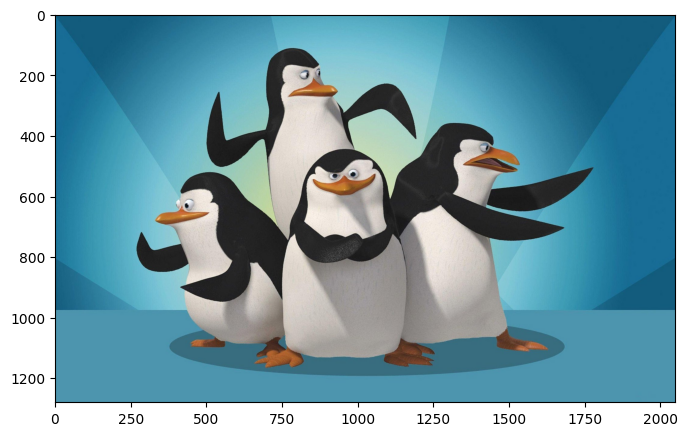

In [6]:
# Просмотр изображений (оригинал)
print(img_orig.shape)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

(1280, 2048, 3)


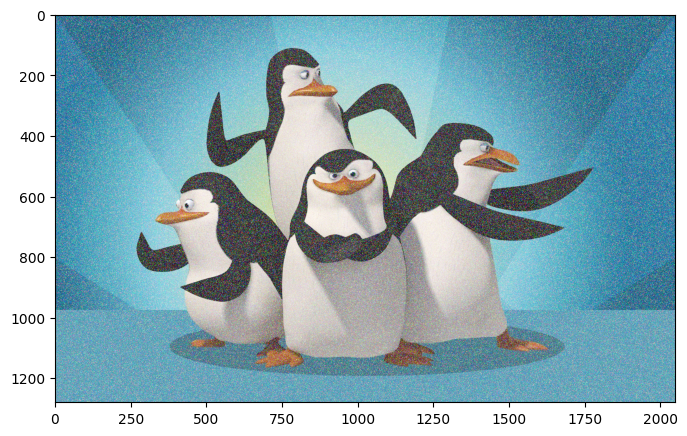

In [7]:
# Просмотр изображений (с шумом)
print(img_noise.shape)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_noise, cv2.COLOR_BGR2RGB))

(1280, 2048, 3)


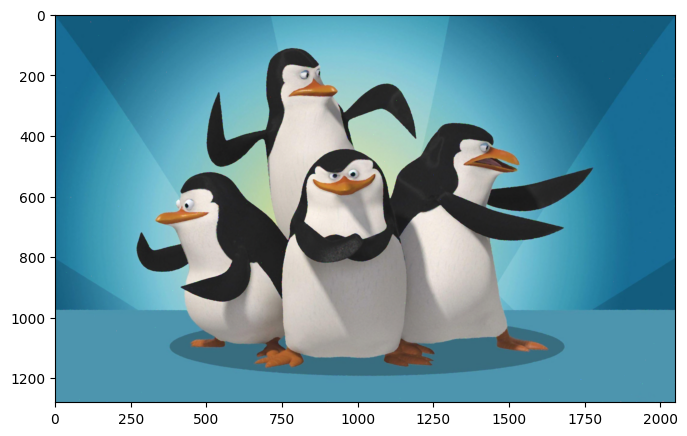

In [8]:
# Просмотр изображений (с шумоподавлением)
print(img_denoise.shape)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_denoise, cv2.COLOR_BGR2RGB))

In [9]:
def eval_dataloss(img1, img2, img3):
    mse = np.square((img1 - img2).astype('float32')).mean()
    print('Среднеквадратическая ошибка для изображения с шумом:', mse)
    mse = np.square((img1 - img3).astype('float32')).mean()
    print('Среднеквадратическая ошибка для изображения с шумоподавлением:', mse)

In [10]:
eval_dataloss(img_orig,img_noise,img_denoise)

Среднеквадратическая ошибка для изображения с шумом: 13490.854
Среднеквадратическая ошибка для изображения с шумоподавлением: 24759.17
